In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import glob
import re

In [2]:
%matplotlib inline

# Analysis scope parameter

The parameter below controls whether to include "Swift long" libraries.

In [3]:
INCLUDE_SWIFT_LONG_LIBS = False

# Utility function

In [4]:
def savefig(name, main=True):
    if main:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-main-withLong/{}'.format(name))
        else:
            plt.savefig('plots-main/{}'.format(name))
    else:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-suppl-withLong/{}'.format(name))
        else:
            plt.savefig('plots-suppl/{}'.format(name))

##  1. Test -- Read one file

In [5]:
df = pd.read_csv("50_variant_analysis/Quanta-100ng-1-aa_happy/Quanta-100ng-1-aa.roc.all.csv.gz")

In [6]:
df.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,...,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
0,INDEL,*,*,ALL,*,CNN_2D,*,0.620173,0.808697,0.197562,...,43333.000000,NaN,1.144855,120677,.,.,51952.000000,67708.000000,NaN,0.767295
1,INDEL,*,*,ALL,*,CNN_2D,-0.191000,0.539400,0.854280,0.117634,...,.,NaN,NaN,53892,.,.,.,.,NaN,NaN
2,INDEL,*,*,ALL,*,CNN_2D,-0.692000,0.567674,0.844496,0.134068,...,.,NaN,NaN,66625,.,.,.,.,NaN,NaN
3,INDEL,*,*,ALL,*,CNN_2D,-1.193000,0.588574,0.835449,0.148820,...,.,NaN,NaN,78832,.,.,.,.,NaN,NaN
4,INDEL,*,*,ALL,*,CNN_2D,-1.694000,0.602765,0.827501,0.162059,...,.,NaN,NaN,90135,.,.,.,.,NaN,NaN


In [7]:
data = df[(df.Type=="SNP") & (df.Filter=="ALL") & (df['QQ.Field'] == "CNN_2D") 
                          & (df['QQ'] != '*') & (df.Subset == "*")]
cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
data[cols] = data[cols].apply(pd.to_numeric, axis=1)
data = data.sort_values('QQ')

/ypool/applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [8]:
data = data[data['METRIC.Precision'] > data['METRIC.Precision'].shift(fill_value=0)]

In [9]:
data.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,...,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
1823,SNP,*,*,ALL,*,CNN_2D,-16.118,0.763791,0.927981,0.063611,...,.,1.843194,NaN,202411,112285.000000,90336.000000,.,.,1.242971,NaN
1822,SNP,*,*,ALL,*,CNN_2D,-15.616,0.763729,0.928006,0.063163,...,.,NaN,NaN,200866,.,89471.000000,.,.,NaN,NaN
1821,SNP,*,*,ALL,*,CNN_2D,-15.115,0.763726,0.928008,0.063128,...,.,NaN,NaN,200748,.,89401.000000,.,.,NaN,NaN
1820,SNP,*,*,ALL,*,CNN_2D,-14.611,0.763725,0.928011,0.063092,...,.,NaN,NaN,200622,.,89323.000000,.,.,NaN,NaN
1819,SNP,*,*,ALL,*,CNN_2D,-14.109,0.763723,0.928015,0.063056,...,.,NaN,NaN,200499,.,.,.,.,NaN,NaN


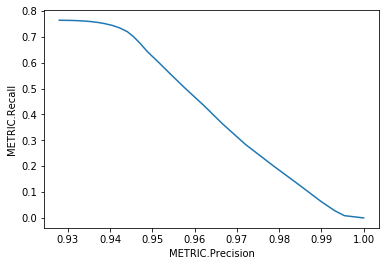

In [10]:
sns.lineplot(x="METRIC.Precision", y="METRIC.Recall", data=data)

In [11]:
xs = [row['METRIC.Precision'] for i, row in data.iterrows()]
ys = [row['METRIC.Recall'] for i, row in data.iterrows()]

In [12]:
ys[-3]

0.027342

Text(0, 0.5, 'Recall (Sensitivity) = TP / (TP + FN)')

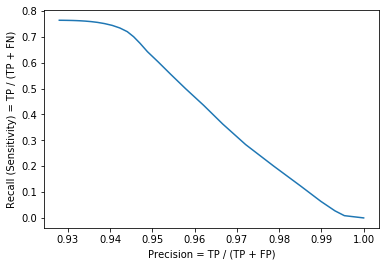

In [13]:
plt.plot(xs, ys)
plt.xlabel("Precision = TP / (TP + FP)")
plt.ylabel("Recall (Sensitivity) = TP / (TP + FN)")

## 2. Read all the hap.py result files

Load data for SNP and INDEL groups (then subset later).

In [14]:
files = glob.glob("50_variant_analysis/*/*-aa.roc.all.csv.gz")
dataframes = []
for file in files:
    m = re.search(r"([^/]+)-(100?ng)-(\d)-aa\.", file)
    kit, conc, rep = m.groups()
    if not INCLUDE_SWIFT_LONG_LIBS and kit == "Swiftlong":
        continue
    data = pd.read_csv(file)
    data = data[(data.Filter=="ALL") & (data['QQ.Field'] == "CNN_2D") 
                  & (data['QQ'] != '*') & (data.Subset == "*") & (data.Subtype == "*")]
    cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
    data = data[cols].apply(pd.to_numeric, axis=1).assign(Type=data.Type)
    # The next line is not necessary unless the one after that (stop=...) is also used
    #data = data.groupby("Type", as_index=False).apply(lambda x: x.sort_values('QQ'))
    # Include higher QQ values until Precision starts dropping
    #stop = (data['METRIC.Precision'] > data['METRIC.Precision'].shift(fill_value=0)).idxmin()
    data = data[data['METRIC.Recall'] > 0.01]
    data['Kit'] = kit
    data['Conc'] = conc
    data['Replicate'] = rep
    dataframes.append(data)
data = pd.concat(dataframes).reset_index(drop=True)
data['Kit'] = pd.Categorical(data.Kit)
data['Conc'] = pd.Categorical(data.Conc, categories=['10ng', '100ng'])

### Distribution of QQ values in SNPs

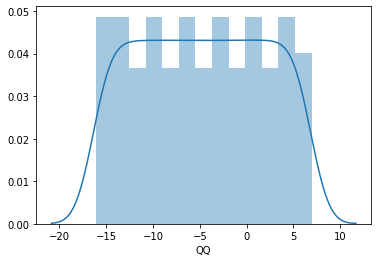

In [15]:
sns.distplot(data[data.Type=="SNP"].QQ)

In [16]:
data.Kit.cat.categories

Index(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'], dtype='object')

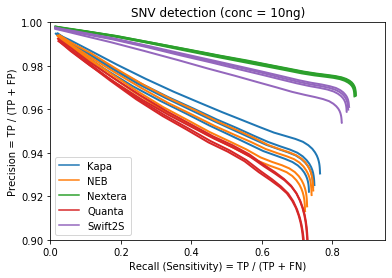

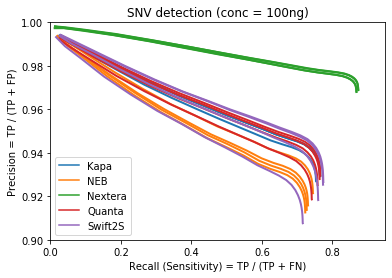

In [17]:
for conc in ["10ng", "100ng"]:
    plt.figure()
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit", 
                 style="Replicate", linewidth=2, dashes=False,
                 data=data[(data.Conc==conc) & (data.Type=="SNP")])
    plt.ylim(0.9, 1.0)
    plt.xlim(0.0, 0.95)
    plt.ylabel("Precision = TP / (TP + FP)")
    plt.xlabel("Recall (Sensitivity) = TP / (TP + FN)")
    plt.title("SNV detection (conc = {})".format(conc))
    g.legend_.remove()
    
    custom_lines = [Line2D([0], [0], color=colour)
                    for _, colour in 
                    zip(data.Kit.cat.categories, sns.color_palette())]
    plt.legend(custom_lines, data.Kit.cat.categories, loc="lower left")
    savefig("snv_{}.pdf".format(conc), False)
    plt.show()


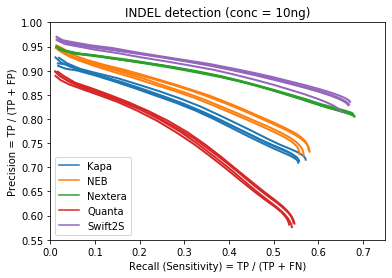

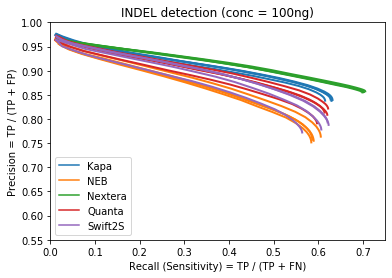

In [18]:
for conc in ["10ng", "100ng"]:
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", style="Replicate",
                 hue="Kit", linewidth=2, dashes=False,
                 data=data[(data.Conc==conc) & (data.Type == "INDEL")])
    plt.ylim(0.55, 1.0)
    plt.xlim(0.0, 0.75)
    plt.ylabel("Precision = TP / (TP + FP)")
    plt.xlabel("Recall (Sensitivity) = TP / (TP + FN)")
    plt.title("INDEL detection (conc = {})".format(conc))
    g.legend_.remove()

    custom_lines = [Line2D([0], [0], color=colour)
                for _, colour in 
                zip(data.Kit.cat.categories, sns.color_palette())]
    plt.legend(custom_lines, data.Kit.cat.categories, loc="lower left")
    savefig("indel_{}.pdf".format(conc), False)
    plt.show()

In [19]:
data.head()

,METRIC.Recall,METRIC.Precision,QQ,Type,Kit,Conc,Replicate
0,0.522743,0.840007,-0.117,INDEL,Swift2S,100ng,1
1,0.552185,0.828119,-0.618,INDEL,Swift2S,100ng,1
2,0.573683,0.816342,-1.118,INDEL,Swift2S,100ng,1
3,0.588352,0.805129,-1.619,INDEL,Swift2S,100ng,1
4,0.606748,0.778341,-10.154,INDEL,Swift2S,100ng,1


## Filtering

We need a more sane filter threshold. hap.py does not filter them for us!

First find the highest F1 value. Just for information, this is not necessarily an important selection.

Text(0.5, 1.0, 'Sensitivity & sensitivity at max F1')

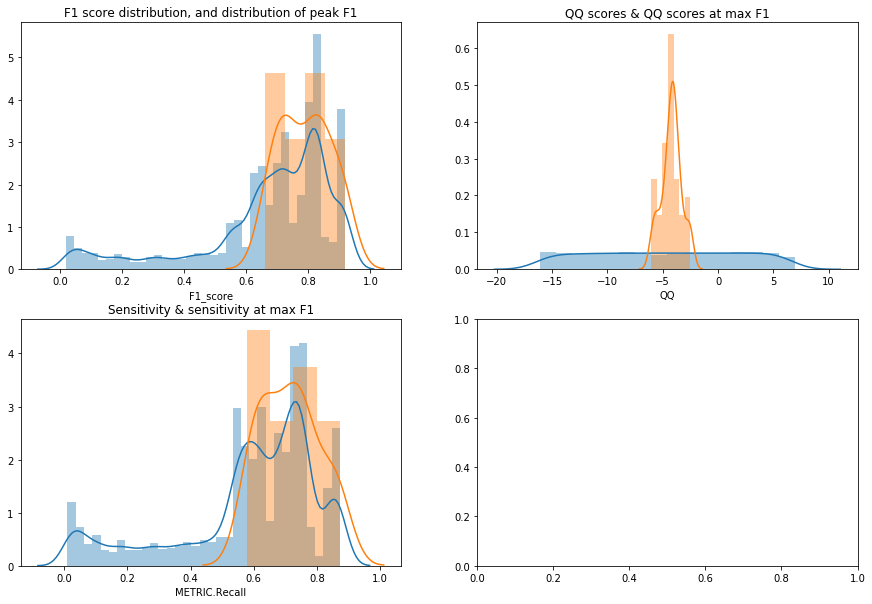

In [20]:
data['F1_score'] = 2*(data['METRIC.Recall'] * data['METRIC.Precision']) / (data['METRIC.Recall'] + data['METRIC.Precision'])
highest_f1 = data.groupby(["Type", "Kit", "Replicate"]).apply(
                    lambda x: x.sort_values('F1_score', ascending=False).head(n=1)
                )
f, axs = plt.subplots(2,2, figsize=(15,10))
sns.distplot(data['F1_score'], ax=axs[0,0])
sns.distplot(highest_f1.F1_score, ax=axs[0,0])
axs[0,0].set_title("F1 score distribution, and distribution of peak F1")
sns.distplot(data.QQ, ax=axs[0,1])
sns.distplot(highest_f1.QQ, ax=axs[0,1])
axs[0,1].set_title("QQ scores & QQ scores at max F1")
sns.distplot(data['METRIC.Recall'], ax=axs[1,0])
sns.distplot(highest_f1['METRIC.Recall'], ax=axs[1,0])
axs[1,0].set_title("Sensitivity & sensitivity at max F1")


# Apply quality (QQ) threshold and then take the average

Using the a cut-off of CNN_2D (QQ score) > -5, for a comparable set of values.

In [21]:
def get_min_qq_row_for_replicate(group_df):
    return group_df.loc[group_df.QQ.idxmin()]

def get_mean_over_replicates(l):
    return l.groupby("Replicate").apply(get_min_qq_row_for_replicate).mean()

quality_thres_mean = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"]).apply(
            get_mean_over_replicates
        )
quality_thres_mean.tail(n=5)

METRIC.Recall  METRIC.Precision       QQ  Replicate  \
Type Kit     Conc                                                         
SNP  Nextera 100ng       0.869882          0.970319 -4.57950      308.5   
     Quanta  10ng        0.724336          0.897558 -4.57525      308.5   
             100ng       0.756428          0.928434 -4.57675      308.5   
     Swift2S 10ng        0.838854          0.960311 -4.58650      308.5   
             100ng       0.754941          0.923481 -4.57725      308.5   

                    F1_score  
Type Kit     Conc             
SNP  Nextera 100ng  0.917358  
     Quanta  10ng   0.801691  
             100ng  0.833637  
     Swift2S 10ng   0.895473  
             100ng  0.830637

## Summary table

In [22]:
summary = quality_thres_mean[["METRIC.Recall", "METRIC.Precision", "QQ", "F1_score"]]
summary.to_csv("result-tables/vc-performance-summary.txt")
summary

METRIC.Recall  METRIC.Precision       QQ  F1_score
Type  Kit     Conc                                                     
INDEL Kapa    10ng        0.557682          0.715647 -4.65000  0.626823
              100ng       0.625710          0.840529 -4.65050  0.717365
      NEB     10ng        0.570705          0.733085 -4.69650  0.641760
              100ng       0.591187          0.759545 -4.69775  0.664861
      Nextera 10ng        0.679342          0.807743 -4.83325  0.737995
              100ng       0.700290          0.857171 -4.71000  0.770826
      Quanta  10ng        0.541281          0.583067 -4.75175  0.561389
              100ng       0.612988          0.810171 -4.72750  0.697912
      Swift2S 10ng        0.664494          0.827977 -4.59100  0.737281
              100ng       0.603365          0.784706 -4.71775  0.682035
SNP   Kapa    10ng        0.747166          0.928284 -4.57175  0.827908
              100ng       0.761090          0.931841 -4.58150  0.837849
      NEB     10ng        0.733258          0.921532 -4.56825  0.816670
              100ng       0.730455          0.919380 -4.57150  0.814089
      Nextera 10ng        0.863970          0.968362 -4.57525  0.913192
              100ng       0.869882          0.970319 -4.57950  0.917358
      Quanta  10ng        0.724336          0.897558 -4.57525  0.801691
              100ng       0.756428          0.928434 -4.57675  0.833637
      Swift2S 10ng        0.838854          0.960311 -4.58650  0.895473
              100ng       0.754941          0.923481 -4.57725  0.830637

## Box plot

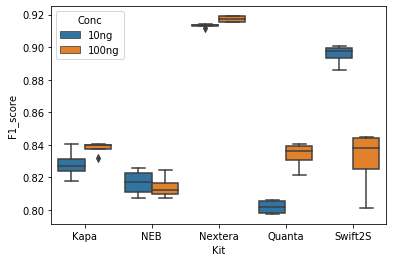

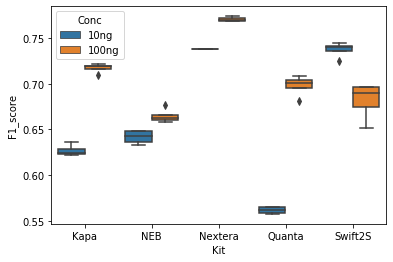

In [23]:
def get_replicates(l):
    return l.groupby("Replicate", as_index=False).apply(get_min_qq_row_for_replicate)

box_data = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"], as_index=False).apply(get_replicates)

plt.figure()
sns.boxplot(data=box_data[box_data.Type == "SNP"], x="Kit", y="F1_score", hue="Conc")
savefig("vc_snv_qthresh_mean_f1.pdf")
plt.figure()
sns.boxplot(data=box_data[box_data.Type == "INDEL"], x="Kit", y="F1_score", hue="Conc")
savefig("vc_indel_qthresh_mean_f1.pdf")

# Attempt to fit or interpolate ROC curves


So the replicates can be combined into an uncertainty band.

## Determine density of data

The plots below show that data the ROC curves can be approximated by a linear interpolation between points.

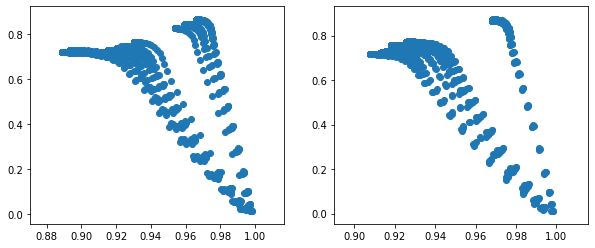

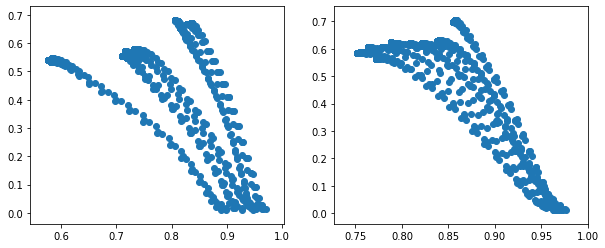

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, conc in enumerate(["10ng", "100ng"]):
    snp_data = data[(data.Conc==conc) & (data.Type=="SNP")]
    axs[i].scatter(snp_data.loc[:, "METRIC.Precision"], snp_data.loc[:, "METRIC.Recall"])
fig.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, conc in enumerate(["10ng", "100ng"]):
    snp_data = data[(data.Conc==conc) & (data.Type=="INDEL")]
    axs[i].scatter(snp_data.loc[:, "METRIC.Precision"], snp_data.loc[:, "METRIC.Recall"])

## Resample the columns by interpolation

In [25]:
# Primary code in development, and series definition
newrecall = pd.Index(np.linspace(0, 1, num=201))

In [26]:
def resample(groupdata):
    dedup = groupdata.drop_duplicates('METRIC.Recall')
    # Create series with all recall values as index, both original ones and ones at fixed interval
    precision_values = dedup.set_index('METRIC.Recall')['METRIC.Precision'].reindex(
        pd.Index(dedup['METRIC.Recall']).union(newrecall)
    )
    # Resulting series contains recall as index and precision as values, and only the new
    # recall values, not the original values. (See above cell for newrecall)
    precision_series = precision_values.interpolate(method='values').loc[newrecall]
    # Blank all values after the last known data point (default is to set these to the last
    # sensitivity value)
    max_data_precision = dedup['METRIC.Recall'].max()
    precision_series[precision_series.index > max_data_precision] = np.nan
    precision_series.index.name = 'METRIC.Recall'
    # Data frame to return:
    return precision_series.to_frame()

In [27]:
resampled_df1 = data.groupby(["Type", "Conc", "Kit", "Replicate"]).apply(resample)
resampled_df1.tail()

METRIC.Precision
Type Conc  Kit     Replicate METRIC.Recall                  
SNP  100ng Swift2S 4         0.980                       NaN
                             0.985                       NaN
                             0.990                       NaN
                             0.995                       NaN
                             1.000                       NaN

## Restrict to range covered by all replicates

In [28]:
resampled_df = resampled_df1.groupby(level=['Type', 'Conc', 'Kit', 'METRIC.Recall']).apply( # Note: not "Replicate" lvl
        # The second clause in the ternary returns a dataframe with all NaNs
        lambda d: d if not d['METRIC.Precision'].hasnans else pd.DataFrame().reindex_like(d)
)

In [29]:
resampled_df.head(n=1)

,,,,,METRIC.Precision
Type,Conc,Kit,Replicate,METRIC.Recall,
INDEL,10ng,Kapa,1,0.0,NaN


## Check by plotting the original way

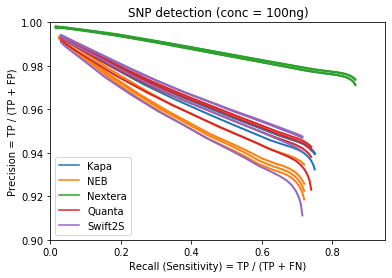

In [30]:
conc = "100ng"
use_data=resampled_df.loc[('SNP', conc)].reset_index()
plt.figure()
g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit", 
             style="Replicate", linewidth=2, dashes=False, data=use_data)
plt.ylim(0.9, 1.0)
plt.xlim(0.0, 0.95)
plt.ylabel("Precision = TP / (TP + FP)")
plt.xlabel("Recall (Sensitivity) = TP / (TP + FN)")
plt.title("SNP detection (conc = {})".format(conc))
g.legend_.remove()

custom_lines = [Line2D([0], [0], color=colour)
                for _, colour in 
                zip(data.Kit.cat.categories, sns.color_palette())]
plt.legend(custom_lines, data.Kit.cat.categories, loc="lower left")
plt.show()


## Plotting the results

In [31]:
resampled_df.loc[('SNP', '100ng', 'Kapa')].head(n=1)

,,METRIC.Precision
Replicate,METRIC.Recall,
1,0.0,NaN


## `n_boot`

Parameter `n_boot` is the number of bootstraps for generating the confidence band. Require a value greater than 1000 to have a smooth band, but this takes several minutes to generate. Default in matplotlib is 1000.

* Set to 50 for quick-and-dirty plot.
* Set to 3333 for nice plots if not Swift long libraries included (see parameter at the top of this notebook)
* Set to 5555 for nice plots if Swift long libraries included (slow!)

In [34]:
n_boot = 50
#n_boot = 6666 if INCLUDE_SWIFT_LONG_LIBS else 3333

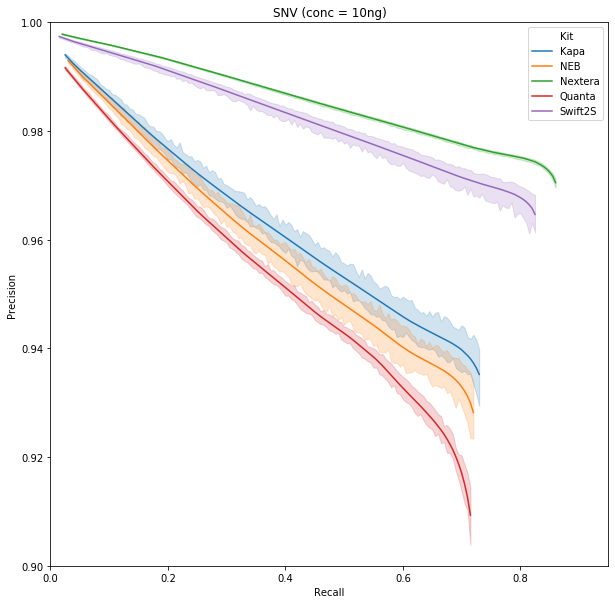

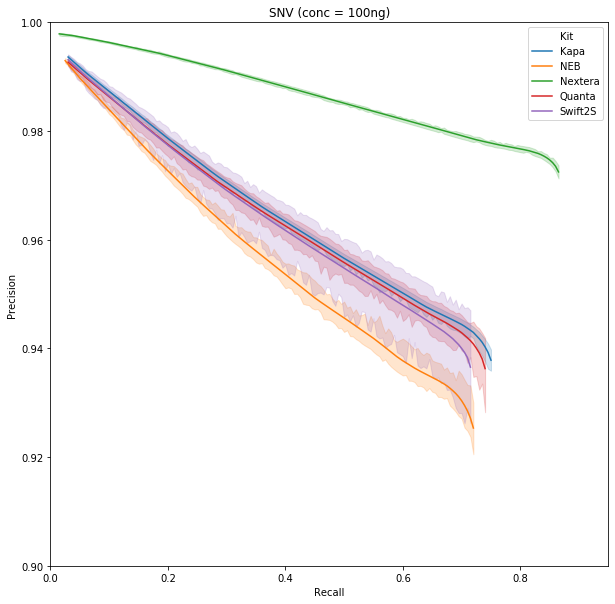

In [35]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit",
                     n_boot=n_boot,
                     data=resampled_df.loc[('SNP', conc)].reset_index())
    plt.ylim(0.9, 1.0)
    plt.xlim(0.0, 0.95)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("SNV (conc = {})".format(conc))
    savefig("snv_rs_{}.pdf".format(conc))
    plt.show()

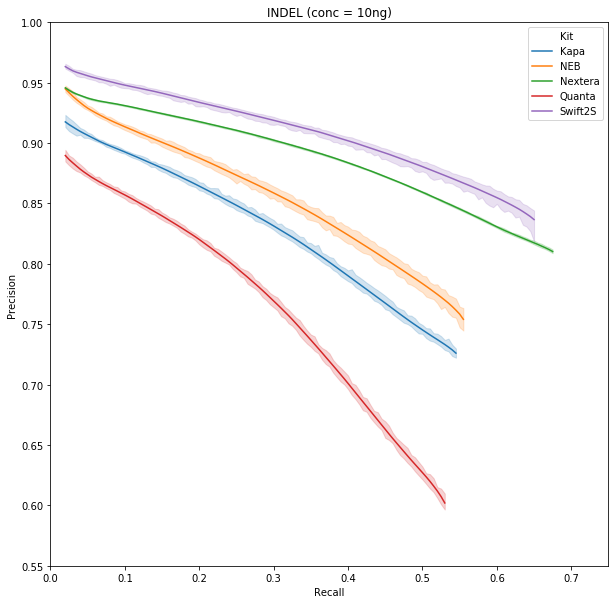

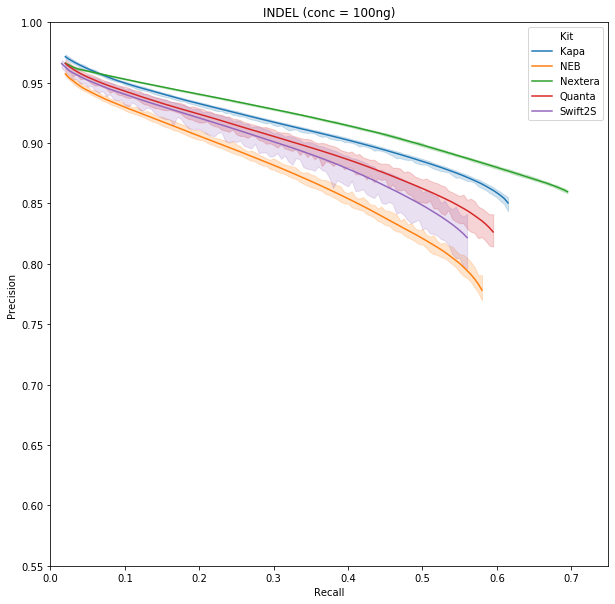

In [36]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit",
                     n_boot=n_boot, data=resampled_df.loc[('INDEL', conc)].reset_index())
    plt.ylim(0.55, 1.0)
    plt.xlim(0.0, 0.75)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("INDEL (conc = {})".format(conc))
    savefig("indel_rs_{}.pdf".format(conc))
    plt.show()